# Deep Learning Models

A collection of deep learning models implemented on Pytorch for training purposes.

Author: Lucas Martinuzzo Batista<br>
GitHub: https://github.com/LucasMartinuzzo/Deep-Learning-Models

## LeNet-5

Implementation ofLeNet-5, the first popular Convolutional Neural Network.

![The Architecture of Lenet-5](../../images/lenet5.png)

Paper: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_blobs
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import time

In [2]:
device = "cpu"
if torch.cuda.is_available():
    print("Cuda is Available!")
    device = torch.device("cuda")
    torch.backends.cudnn.deterministic = True

Cuda is Available!


### Dataset

In [3]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1024

In [4]:
#transforms.ToTensor() normalizes the image from 0 - 255 to 0 - 1.
train_dataset = datasets.FashionMNIST(root="../../data/",
                                      train=True,
                                      download=True,
                                      transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root="../../data/",
                                      train=False,
                                      download=False,
                                      transform=transforms.ToTensor())

In [5]:
train_size = len(train_dataset)
test_size = len(test_dataset)

In [6]:
train_loader = DataLoader(train_dataset,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=TEST_BATCH_SIZE)

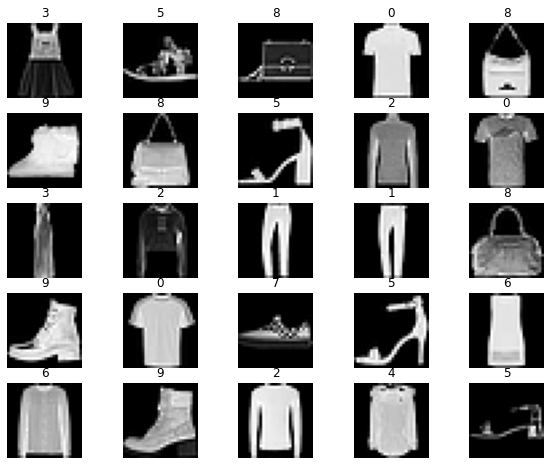

In [7]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Network

In [8]:
NUM_FEATURES = 28*28
NUM_CLASSES = 10
RANDOM_SEED = 42

In [9]:
torch.manual_seed(RANDOM_SEED)

In [10]:
class LeNet5(nn.Module):
  #Constructor
    def __init__(self,num_classes):
        super(LeNet5,self).__init__()
        # I'm adding a padding of 2, to simulate the image size as 32x32 as used in the paper
        # I'm using max pooling because it gives better results than average pooling
        
        # 28x28x1 -> 32x32x1 -> 28x28x6
        self.cv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,padding=2,padding_mode='zeros')
        # 28x28x6 -> 14x14x6
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        #14x14x6 -> 10x10x16
        self.cv3 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5) 
        # 10x10x16 -> 5x5x16
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=2) 
        # 5x5x16 -> 1x1x120
        self.cv5 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5) 
        # 120 -> 84
        self.fc6 = nn.Linear(in_features=120,out_features=84) 
        # 84 -> 10
        self.out = nn.Linear(in_features=84,out_features=num_classes) 
        
    
    def forward(self,x):
        #The original paper uses TANH as activation function
        #But ReLU gives better results
        x = self.cv1(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.cv3(x)
        x = torch.relu(x)
        x = self.pool4(x)
        
        x = self.cv5(x)
        x = torch.relu(x)
        
        x = x.view(-1,120)
        x = self.fc6(x)
        x = torch.relu(x)
        
        out= self.out(x)
        
        logits = torch.relu(out)
        probs = nn.functional.log_softmax(logits,dim=1)
        
        return logits, probs

In [11]:
model = LeNet5(NUM_CLASSES)
model.to(device)

LeNet5(
  (cv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.05)
loss_criterion = nn.CrossEntropyLoss()

In [13]:
def train(model,optimizer,loss_function,train_loader,test_loader,epochs,train_size,test_size):
    LOSSES = []
    ACCURACIES = []
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        accumulated_loss = 0
        correct = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits,probs = model(x)
            loss = loss_function(logits,y)
            loss.backward()
            optimizer.step()
            accumulated_loss += loss.item()
            y_hat = probs.argmax(dim=1)
            correct += (y_hat  == y).sum().item()
        LOSSES.append(accumulated_loss)
        train_accuracy = correct/train_size
        model.eval()
        correct = 0
        for x_test,y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            logits,probs = model(x_test)
            y_hat = probs.argmax(dim=1)
            correct += (y_hat  == y_test).sum().item()
        test_accuracy = correct/test_size
        print("Epoch {}/{}. Cost: {:.2f}. Train Accuracy: {:.2f}. Test Accuracy: {:.2f}".format(
                epoch+1,epochs,accumulated_loss,100*train_accuracy,100*test_accuracy))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        ACCURACIES.append(test_accuracy)
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return LOSSES,ACCURACIES

In [14]:
LOSS, ACC = train(model,optimizer,loss_criterion,train_loader,test_loader,
                  epochs=20,train_size=train_size,test_size=test_size)

Epoch 1/20. Cost: 1263.23. Train Accuracy: 50.95. Test Accuracy: 76.25
Time elapsed: 0.20 min
Epoch 2/20. Cost: 496.88. Train Accuracy: 80.30. Test Accuracy: 81.52
Time elapsed: 0.39 min
Epoch 3/20. Cost: 401.78. Train Accuracy: 84.16. Test Accuracy: 84.12
Time elapsed: 0.57 min
Epoch 4/20. Cost: 356.76. Train Accuracy: 85.87. Test Accuracy: 84.62
Time elapsed: 0.75 min
Epoch 5/20. Cost: 327.46. Train Accuracy: 87.00. Test Accuracy: 85.22
Time elapsed: 0.93 min
Epoch 6/20. Cost: 306.06. Train Accuracy: 87.89. Test Accuracy: 84.21
Time elapsed: 1.11 min
Epoch 7/20. Cost: 289.01. Train Accuracy: 88.64. Test Accuracy: 85.58
Time elapsed: 1.29 min
Epoch 8/20. Cost: 275.60. Train Accuracy: 89.06. Test Accuracy: 88.59
Time elapsed: 1.47 min
Epoch 9/20. Cost: 263.04. Train Accuracy: 89.48. Test Accuracy: 88.65
Time elapsed: 1.65 min
Epoch 10/20. Cost: 251.81. Train Accuracy: 90.12. Test Accuracy: 87.30
Time elapsed: 1.83 min
Epoch 11/20. Cost: 243.32. Train Accuracy: 90.31. Test Accuracy: 88.

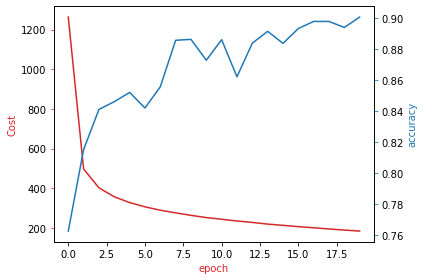

In [15]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(LOSS, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( ACC, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()